In [69]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import shap
import matplotlib.pyplot as plt
import missingno as msn
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')



from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from tpot import TPOTClassifier

In [70]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test= pd.read_csv('../input/spaceship-titanic/test.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


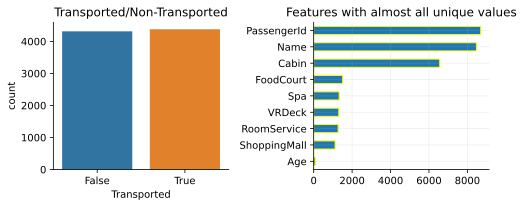

In [71]:
fig, axes = plt.subplots(ncols=2, figsize=(7,3))
sns.countplot(train['Transported'], ax=axes[0])
axes[0].set_title('Transported/Non-Transported')
train_uniqs = train.nunique().sort_values()
train_uniqs[train_uniqs>4].plot.barh(edgecolor='yellow', ax=axes[1])
axes[1].grid(alpha=.2     )
for spine in ['right','top']:
    axes[1].spines[spine].set_visible(False)
axes[1].set_title('Features with almost all unique values')

sns.despine()
plt.tight_layout()
train['Group'] = train.PassengerId.apply(lambda x: x[:4])
train = train.drop(['Name','PassengerId'], axis=1)


In [72]:
train['Cabin_f'] = train.Cabin.apply(lambda x: str(x)[:1])
train['Cabin_n'] = train.Cabin.apply(lambda x: str(x)[2])
train['Cabin_b'] = train.Cabin.apply(lambda x: str(x)[-1:])
train.pop('Cabin')

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [73]:
test= pd.read_csv('../input/spaceship-titanic/test.csv')

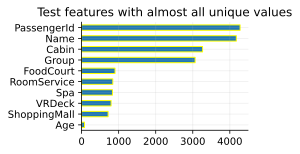

In [74]:
test_id = test['PassengerId']
test['Group'] = test.PassengerId.apply(lambda x: x[:4])
fig = plt.figure(figsize=(3,2                         ))
axe = plt.axes()
train_uniqs = test.nunique().sort_values()
train_uniqs[train_uniqs>4].plot.barh(edgecolor='yellow', ax=axe)
for spine in ['right','top']:
    axe.spines[spine].set_visible(False)
axe.grid(alpha=.2)
axe.set_title('Test features with almost all unique values')
test['Cabin_f'] = test.Cabin.apply(lambda x: str(x)[:1])
test['Cabin_n'] = test.Cabin.apply(lambda x: str(x)[2])
test['Cabin_b'] = test.Cabin.apply(lambda x: str(x)[-1:])
plt.show()
test.pop('Cabin')
test = test.drop(['Name','PassengerId'], axis=1)

In [75]:
y_train = train.pop('Transported')
y_train = y_train.apply(lambda x: 1 if x is True else 0)
StanScl = StandardScaler()
LabelEnc = LabelEncoder()
cols = train.select_dtypes('object').columns
comb = train[cols].append(test[cols])
for col in comb.columns:
    comb[col] = LabelEnc.fit(comb[col])
    train[col] = LabelEnc.transform(train[col])
    test[col] = LabelEnc.transform(test[col])
train = train.fillna(train.median())
test = test.fillna(test.median())
X_train = train
X_test = test
X_train[X_train.columns] = StanScl.fit_transform(X_train)
X_test[X_test.columns] = StanScl.transform(X_test)

In [76]:
def show_metrics(metrics): 
    try:return pd.DataFrame(metrics).set_index('classifier') 
    except:return pd.DataFrame([metrics]).set_index('classifier')   
def metrics(estimators, X_train, y_train): 
    metrics = []
    for name, model in estimators.items():
        fig, axes = plt.subplots(ncols=3, figsize=(12,4))
        mod = model.fit(X_train, y_train)
        y_pred = mod.predict(X_train)
        plot_precision_recall_curve(mod, X_train, y_train,
                                    ax=axes[0], color='black')
        plot_roc_curve(mod, X_train, y_train, drop_intermediate=True,
                       ax = axes[1], color='black')
        axes[0].set_title(f'Precision-Recall Curve for {name}')
        axes[1].plot([1,0],[1,0], c='green',ls='--', lw=.9)
        axes[1].set_title(f'ROC Curve for {name}')
        for ax in axes.ravel():
            ax.legend(frameon=False)
        for spine in ['top','right']:
            for ax in axes:
                ax.spines[spine].set_visible(False)
                ax.legend(loc='lower center', frameon=False, fontsize=9)
        scores = {}
        scores['classifier'] = name
        scores['accuracy_score'] = accuracy_score(y_train, y_pred)
        scores['roc_auc_score']=roc_auc_score(y_train, y_pred)
        scores['f1_score'] = f1_score(y_train,y_pred)
        plt.tight_layout()
        metrics.append(scores)
    return show_metrics(metrics)

,accuracy_score,roc_auc_score,f1_score
classifier,,,
GradientBoosting,0.849764,0.849670,0.852596
LGBM,0.879328,0.879338,0.879936


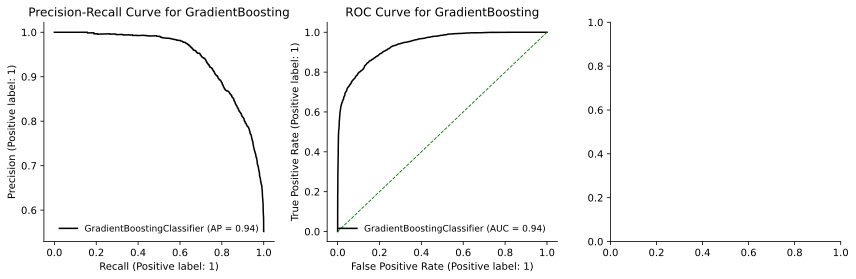

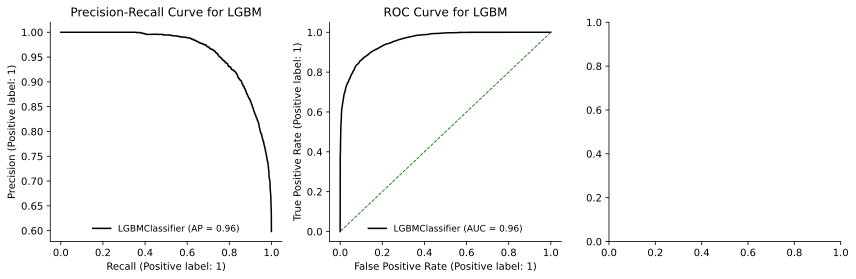

In [77]:
GradientBoosting = GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=5, max_features=0.7000000000000001,
                                 min_samples_leaf=18, min_samples_split=11, n_estimators=100, subsample=0.7500000000000001)
LightGBM = LGBMClassifier(random_state=42)
estimators = {'GradientBoosting':GradientBoosting, 'LGBM':LightGBM}
metrics(estimators, X_train, y_train)

In [78]:
y_pred = LightGBM.predict(X_test)
y_pred = y_pred.astype('bool')
submission = pd.DataFrame({'PassengerId':test_id,'Transported': y_pred})
submission.to_csv('submission.csv', index=False)